In [7]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction recontruction (DL2)

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

based on previous work by J. Lefacheur.

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding the angular distribution of the showers selected for DL3 data.

**NOTES:**

- a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
- follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 data produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update
* add remaining benchmarks from CTA-MARS comparison
* same for EventDisplay

## Table of contents
   - [Energy-dependent offset distribution](#Energy-dependent-offset-distribution)
   - [Angular resolution](#Angular-resolution)
   - [PSF asymmetry](#PSF-asymmetry)

## Imports

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
cmap = dict()
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
from pathlib import Path
import numpy as np
import pandas as pd

import astropy.coordinates as c
import astropy.wcs as wcs
import astropy.units as u
import matplotlib.pyplot as plt

## Functions

In [16]:
def compute_psf(data, ebins, radius):
    nbin = len(ebins) - 1
    psf = np.zeros(nbin)
    psf_err = np.zeros(nbin)
    for idx in range(nbin):
        emin = ebins[idx]
        emax = ebins[idx+1]
        sel = data.loc[(data['true_energy'] >= emin) & (data['true_energy'] < emax), ['xi']]
        if len(sel) != 0:
            psf[idx] = np.percentile(sel['xi'], radius)
            psf_err[idx] = psf[idx] / np.sqrt(len(sel))
        else:
            psf[idx] = 0.
            psf_err[idx] = 0.
    return psf, psf_err

def plot_psf(ax, x, y, err, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    xlabel = kwargs.get('xlabel', '')
    xlim = kwargs.get('xlim', None)
    
    ax.errorbar(x, y, yerr=err, fmt='o', label=label, color=color) #, yerr=err, fmt='o') #, color=color, label=label)
    ax.set_ylabel('PSF (68% containment)')
    ax.set_xlabel('True energy [TeV]')
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax

## Load data

In [10]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

In [11]:
parentDir = "/Users/michele/Applications/ctasoft/dirac/" # full path location of the 'shared_folder'
analysisName = "v0.4.0_dev0"

indir = os.path.join(parentDir, "shared_folder/analyses", analysisName, "data/DL2")
infile = 'DL2_tail_gamma_merged.h5'
data_evt = pd.read_hdf(os.path.join(indir, infile), "/reco_events")
good_events = data_evt[(data_evt["is_valid"]==True) & (data_evt["NTels_reco"] >= 2) & (data_evt["gammaness"] >= 0.75)]

## Benchmarks

Here we use events with the following cuts:
- valid reconstructed events
- at least 2 reconstructed images, regardless of the camera
- gammaness > 0.75 (mostly a conservative choice)

### Energy-dependent offset distribution

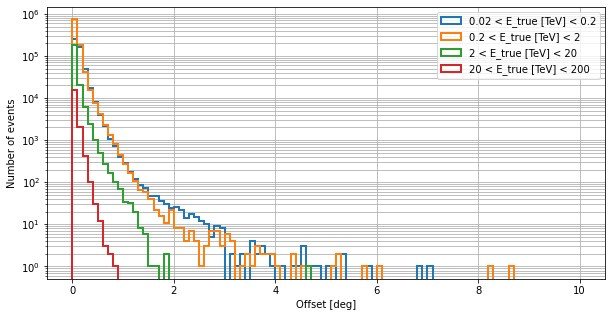

In [13]:
min_true_energy = [0.02, 0.2, 2, 20]
max_true_energy = [0.2, 2, 20, 200]

plt.figure(figsize=(10,5))
plt.xlabel("Offset [deg]")
plt.ylabel("Number of events")

for low_E, high_E in zip(min_true_energy, max_true_energy):
    
    selected_events = good_events[(good_events["true_energy"]>low_E) & (good_events["true_energy"]<high_E)]
    
    plt.hist(selected_events["offset"], 
             bins=100,
             range = [0,10],
             label=f"{low_E} < E_true [TeV] < {high_E}",
             histtype="step",
             linewidth=2)

plt.yscale("log")
plt.legend(loc="best")
plt.grid(which="both")

plt.savefig(f"./plots/DL3_offsets_{analysisName}.png")

plt.show()

### Angular resolution
[back to top](#Table-of-contents)

Here we compare how the multiplicity influences the performance of reconstructed events.

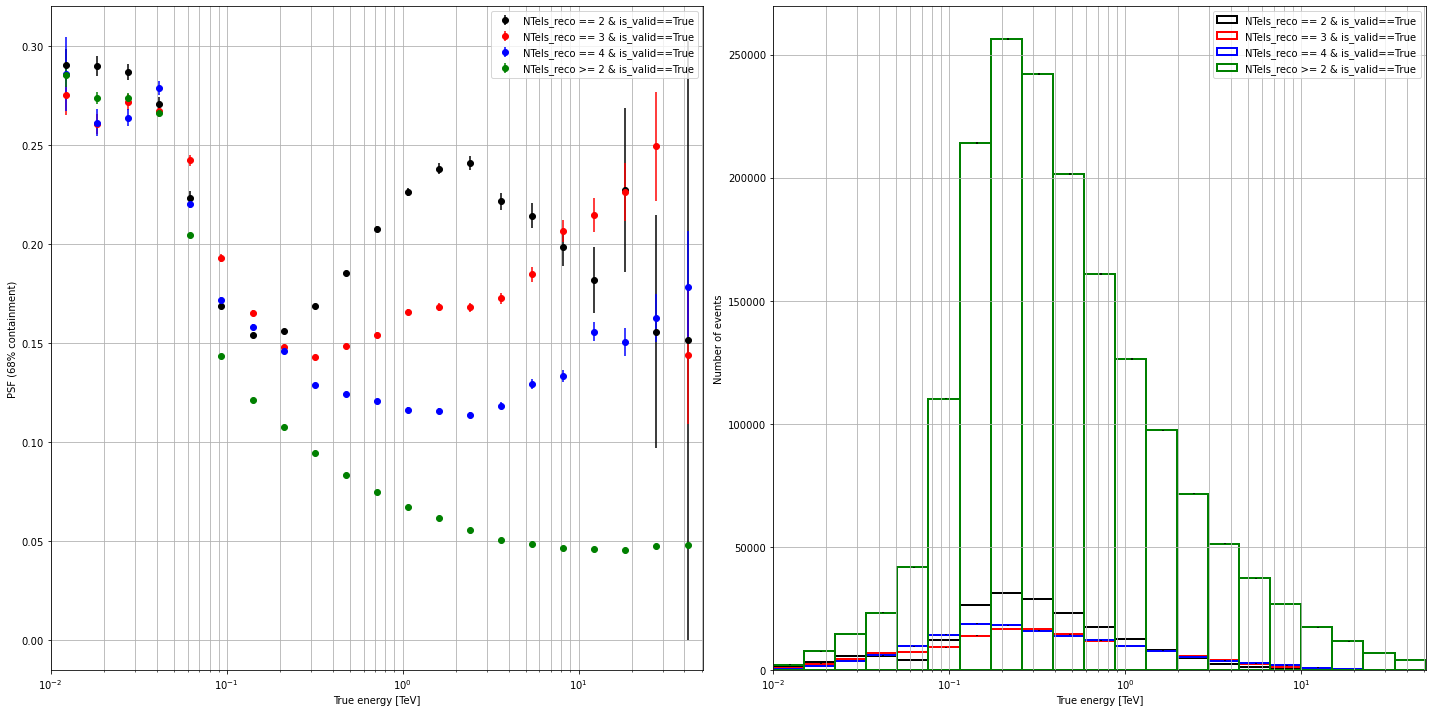

In [17]:
r_containment = 68

energy_bins = 21
max_energy_TeV = 0.0125
min_energy_TeV = 200.0
energy_edges = np.logspace(np.log10(0.01), np.log10(51), energy_bins + 1, True)
energy = np.sqrt(energy_edges[1:] * energy_edges[:-1])
multiplicity_cuts = ['NTels_reco == 2 & is_valid==True',
                     'NTels_reco == 3 & is_valid==True',
                     'NTels_reco == 4 & is_valid==True',
                     'NTels_reco >= 2 & is_valid==True']

events_selected_multiplicity = [good_events[(good_events["NTels_reco"]==2)],
                                good_events[(good_events["NTels_reco"]==3)],
                                good_events[(good_events["NTels_reco"]==4)],
                                good_events[(good_events["NTels_reco"]>=2)]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}

limit = [0.01, 51]
for cut_idx, cut in enumerate(multiplicity_cuts):
    #data_mult = data_evt.query(cut)
    data_mult = events_selected_multiplicity[cut_idx]
    psf, err_psf = compute_psf(data_mult, energy_edges, 68)
    opt={'color': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx]}
    plot_psf(axes[0], energy, psf, err_psf, **opt)
    
    y, tmp = np.histogram(data_mult['true_energy'], bins=energy_edges)
    weights = np.ones_like(y)
    #weights = weights / float(np.sum(y))
    yerr = np.sqrt(y) * weights
    centers = 0.5 * (energy_edges[1:] + energy_edges[:-1])
    width = energy_edges[1:] - energy_edges[:-1]
    axes[1].bar(centers, y * weights, width=width, yerr=yerr, **{'edgecolor': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx], 'lw': 2, 'fill': False})
    axes[1].set_ylabel('Number of events')
    
for ax in axes:
    ax.set_xlim(limit)
    ax.set_xscale('log')
    ax.legend(loc='best')
    ax.grid(which='both')
    ax.set_xlabel('True energy [TeV]')

plt.tight_layout()

fig.savefig(f"./plots/DL3_PSF_{analysisName}.png")

### PSF asymmetry
[back to top](#Table-of-contents)

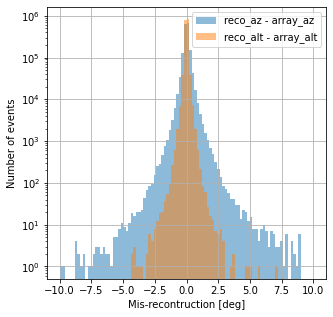

In [18]:
reco_alt = good_events.reco_alt
reco_az = good_events.reco_az
reco_az_corr = reco_az * np.cos(np.deg2rad(good_events.reco_alt))

array_alt = 70
array_az = -180
array_az_corr = array_az * np.cos(np.deg2rad(array_alt))

daz = reco_az - array_az
dalt = reco_alt - array_alt
daz_corr = reco_az_corr - array_az_corr

plt.figure(figsize=(5, 5))

plt.xlabel("Mis-recontruction [deg]")
plt.ylabel("Number of events")

plt.hist(reco_az - array_az, bins=100, range=[-10,10], alpha=0.5, label = "reco_az - array_az")
plt.hist(reco_alt - array_alt, bins=100, range=[-10,10], alpha=0.5, label = "reco_alt - array_alt")

plt.legend()
plt.yscale("log")
plt.grid()


plt.show()

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


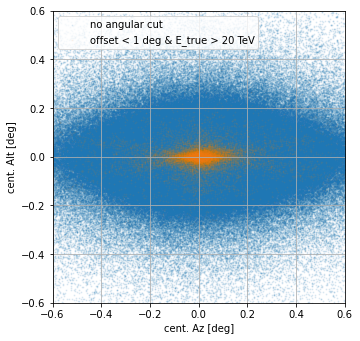

In [20]:
angcut = (good_events['offset'] < 1) & (good_events['true_energy'] > 20)
dx = 0.3

plt.figure(figsize=(5,5))
ax = plt.gca()

ax.scatter(daz, dalt, alpha=0.1, s=1, label='no angular cut')
ax.scatter(daz[angcut], dalt[angcut], alpha=0.05, s=1, label='offset < 1 deg & E_true > 20 TeV')

ax.set_aspect('equal')
ax.set_xlim(-2*dx,2*dx)
ax.set_ylim(-2*dx,2*dx)
ax.set_xlabel('cent. Az [deg]')
ax.set_ylabel('cent. Alt [deg]')
ax.legend()
plt.tight_layout()
plt.grid(which="both")

fig.savefig(f"./plots/PSFasymmetry_2D_altaz_{analysisName}.png")

In [22]:
print('daz = {:.4f} +/- {:.4f} deg'.format(daz.mean(), daz.std()))
print('dalt = {:.4f} +/- {:.4f} deg'.format(dalt.mean(), dalt.std()))

daz = 0.0138 +/- 0.2876 deg
dalt = 0.0002 +/- 0.1109 deg
